Download del dataset

In [1]:
!wget https://raw.githubusercontent.com/bolps/dataset/master/train_breast.csv

--2020-09-15 09:56:21--  https://raw.githubusercontent.com/bolps/dataset/master/train_breast.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.248.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121917 (119K) [text/plain]
Saving to: ‘train_breast.csv’

train_breast.csv    100%[===================>] 119.06K   667KB/s    in 0.2s    

2020-09-15 09:56:22 (667 KB/s) - ‘train_breast.csv’ saved [121917/121917]



**Introduzione**

L'obiettivo del progetto è di risolvere un problema di classificazione binaria relativo al Dataset `Breast Cancer Wisconsin DataSet': un Dataset diagnostico per la classificazione del tumore al seno. All’interno del Dataset ogni paziente ha un identificativo (id) ed è descritto da 30 caratteristiche numeriche e dalla classe (diagnosis) che rappresenta l'esito della diagnosi.

Il dataset oggetto di studio è costituito da 455 casi.
Di seguito si riporta l’elenco delle features presenti nel dataset relative al nucleo cellulare analizzato:
* texture - deviazione standard dei valori della scala dei grigi;
* perimeter - perimetro;
* area - area;
* smoothness - variazione locale;
* compactness - perimeter2/area - 1.0;
* concavity - gravità delle porzioni concave del contorno;
* concave points - numero di porzioni concave del contorno;
* symmetry - simmetria;
* fractal dimension - dimensione frattale.

Per ognuna delle features sono state calcolate la media, l’errore standard e il peggiore (o più grande) ottenendo così un totale di 30 caratteristiche per ogni immagine.

*Il classificatore implementato deve prevedere, sulla base della caratteristiche di input, se il tumore analizzato è benigno o maligno.*



Importazione librerie

In [2]:
import numpy as np
import pandas as pd
import sklearn
import warnings
import seaborn as sns
from matplotlib import pyplot as plt

# per valutazione / metriche
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
from sklearn.metrics import plot_confusion_matrix

# per ricerca modello e parametri
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# per imputazione e visualizzazione missing
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# per riduzione dimensionale
from sklearn.decomposition import PCA

# per ricodifica variabili categoriali
from sklearn.preprocessing import LabelEncoder

# per scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

# classificatori
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# per esportazione modello
from joblib import dump

In [3]:
warnings.filterwarnings('ignore')

**Lettura dataset e visualizzazione**

In [4]:
dataset = pd.read_csv("./train_breast.csv")
dataset = dataset.drop('id',1)

In [5]:
dataset.head(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave.points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave.points_worst,symmetry_worst,fractal_dimension_worst
0,B,12.91,16.33,82.53,516.4,0.07941,0.05366,0.03873,0.02377,0.1829,...,13.88,22.00,90.81,600.6,0.1097,0.1506,0.1764,0.08235,0.3024,0.06949
1,B,14.05,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.04304,0.1537,...,15.30,33.17,100.20,706.7,0.1241,0.2264,0.1326,0.10480,0.2250,0.08321
2,B,13.87,20.70,89.77,584.8,0.09578,0.10180,0.03688,0.02369,0.1620,...,15.05,24.75,99.17,688.6,0.1264,0.2037,0.1377,0.06845,0.2249,0.08492
3,B,14.87,20.21,96.12,680.9,0.09587,0.08345,0.06824,0.04951,0.1487,...,16.01,28.48,103.90,783.6,0.1216,0.1388,0.1700,0.10170,0.2369,0.06599
4,B,12.34,12.27,78.94,468.5,0.09003,0.06307,0.02958,0.02647,0.1689,...,13.61,19.27,87.22,564.9,0.1292,0.2074,0.1791,0.10700,0.3110,0.07592


In [6]:
dataset.shape

(455, 31)

**Analisi esplorativa del dataset**

Verifichiamo se ci sono feature con scale di valore eterogenee

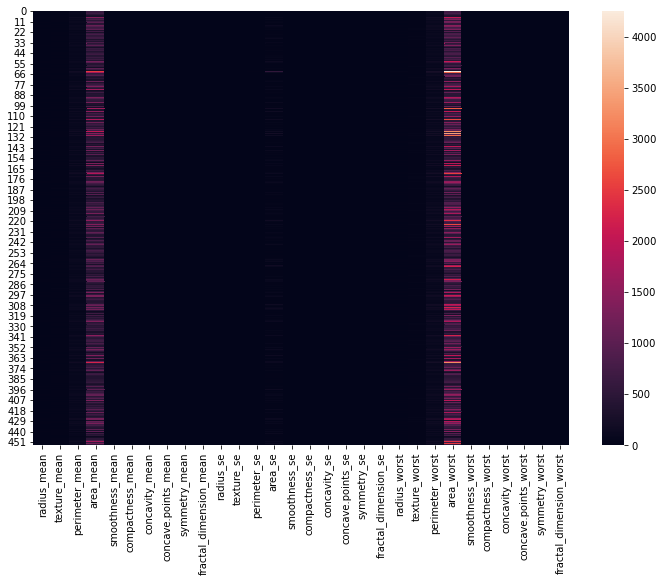

In [7]:
plt.figure(figsize=(12,8))
sns.heatmap(dataset.drop(['diagnosis'],axis=1))
plt.show()

*Con l'utilizzo della heatmap emerge che due features, area_mean e area_worst hanno valori molto più elevati rispetto alle altre. 
Questo suggerisce che sarà necessario uno scaling dei dati.*

Verifichiamo se le classi sono bilanciate

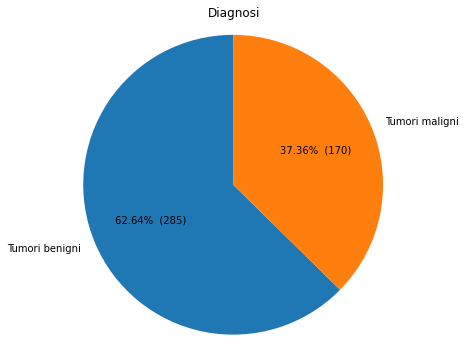

In [8]:
# contiamo il numero di esempi per ogni classe
counts = dataset['diagnosis'].value_counts()
n_B = counts[0]
n_M = counts[1]

labels = ['Tumori benigni', 'Tumori maligni']
values = [counts[0],counts[1]]

fig1, ax1 = plt.subplots(figsize = (6,6))
ax1.pie(values, labels=labels, autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(values)/100), startangle=90)
ax1.axis('equal')
plt.title("Diagnosi")
plt.show()

*L’analisi del dataset consente di osservare un lieve sbilanciamento delle diagnosi con una prevalenza di casi di tumori benigni (62.64%) rispetto ai maligni (37.36%). Questa caratteristica ci porterà a indagare un eventuale bilanciamento delle classi nell'algoritmo di classifcazione*

Visualizzazione dati mancanti

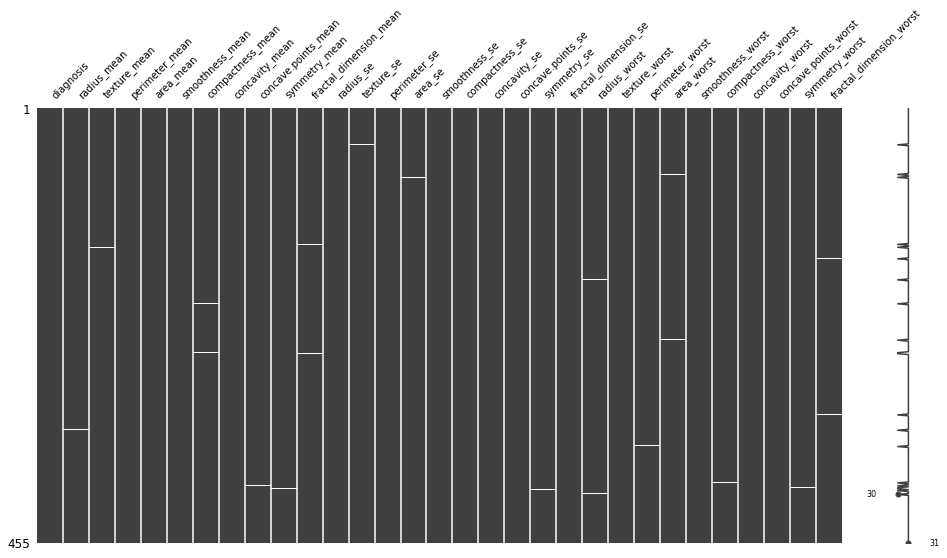

In [9]:
msno.matrix(dataset, figsize = (16,8),fontsize=10)
plt.show()

In [10]:
missing = pd.DataFrame(dataset.isna().sum())
missing.columns = ['n']
missing[missing['n']>0]

,n
radius_mean,1
texture_mean,1
compactness_mean,2
concave.points_mean,1
symmetry_mean,1
fractal_dimension_mean,2
texture_se,1
area_se,1
symmetry_se,1
radius_worst,2


*Nel dataset sono presenti dati mancanti per quanto riguarda le features, non sono invece presenti sulla variabile target (diagnosis). La visualizzazione suggerisce una distribuzione random dei dati mancanti (MAR).*

Visualizzazione della distribuzione delle variabili per classe

In [11]:
def violin_plot(dataset, features, name):
    # scaling del dataset
    df_features = dataset.iloc[:,1:]

    scaler = StandardScaler()
    scaler.fit(df_features)

    features_scaled = scaler.transform(df_features)
    features_scaled = pd.DataFrame(data=features_scaled, columns=df_features.columns)
    df_scaled = pd.concat([features_scaled, dataset['diagnosis']], axis=1)


    df_scaled_melt = pd.melt(df_scaled, id_vars='diagnosis', var_name='features', value_name='value')
    df_scaled_melt.head(3)

    # creazione query
    query = ''
    for x in features:
        query += "features == '" + str(x) + "' or "
    query = query[0:-4]

    # creazione dataframe per visualizzazione
    data = df_scaled_melt.query(query)

    # plot dei dati
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='features',
                   y='value',
                   hue='diagnosis',
                   data=data,
                   split=True,
                   inner="quart")
    plt.xticks(rotation=45)
    plt.title(name)
    plt.xlabel("Features")
    plt.ylabel("Standardize Value")

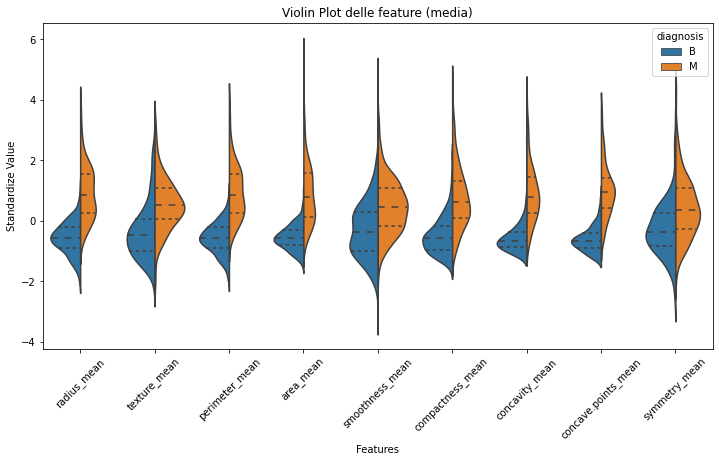

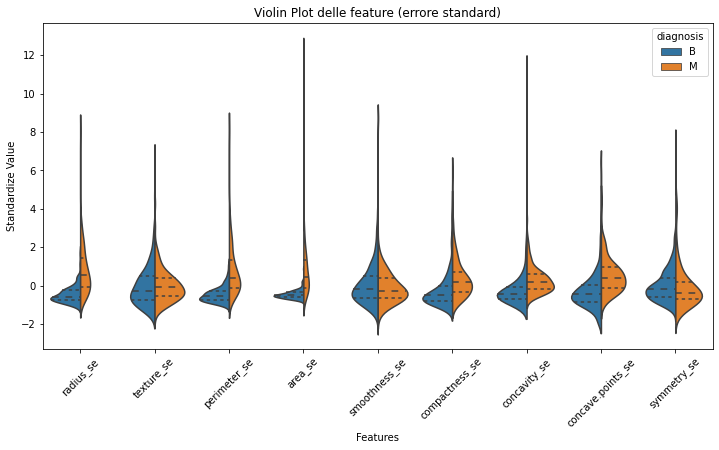

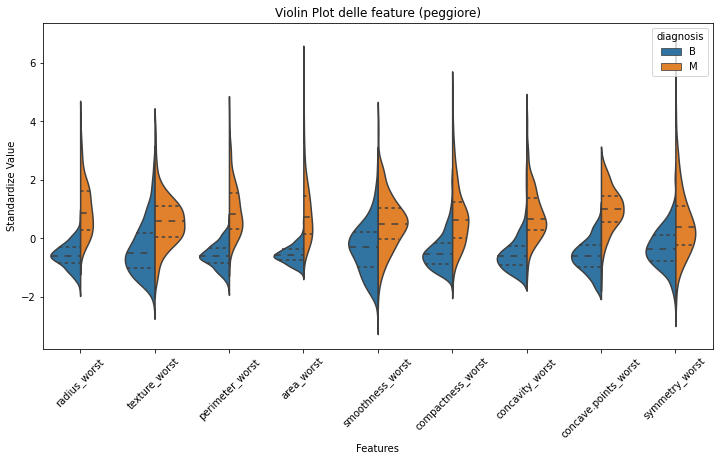

In [12]:
violin_plot(dataset, dataset.columns[0:10], "Violin Plot delle feature (media)")
violin_plot(dataset, dataset.columns[11:20], "Violin Plot delle feature (errore standard)")
violin_plot(dataset, dataset.columns[21:30], "Violin Plot delle feature (peggiore)")

*I violin plot suggeriscono la presenza di una differenza nelle distribuzioni tra casi di tumori benigni e maligni. Inoltre è possibile vedere come in alcune features le code della distribuzione siano lunghe (fenomeno che suggerisce la presenza di outlier).*

*Nota metodologica: per la visualizzazione i dati sono stati standardizzati con zscore in quanto sarebbe stato difficile rappresentare variabili con grandezze così diverse.*

Visualizzazione di correlazioni tra features

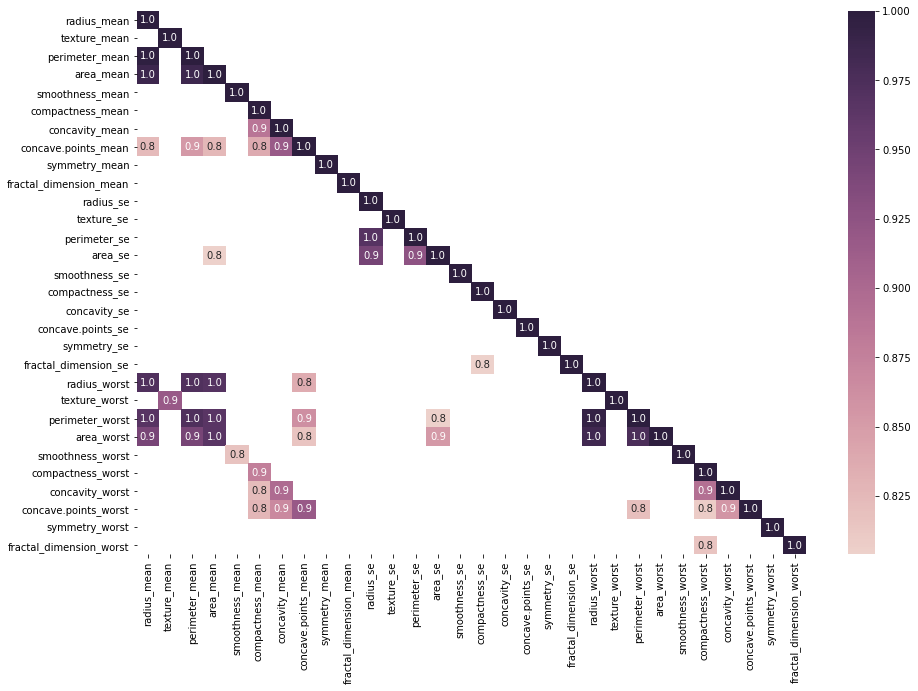

In [13]:
corr_mat = dataset.drop(['diagnosis'],axis=1).corr()
mask = np.zeros_like(corr_mat, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat[corr_mat > 0.8], annot=True,
            fmt='.1f', cmap=sns.cubehelix_palette(200), mask=mask)
plt.show()

*Dal grafico emerge la presenza di più variabili fortemente correlate, situazione che suggerisce una certa ridondanza delle informazioni contenute nelle variabili.*

**Costruzione del classificatore**

Split del dataset in training e test set

In [14]:
# separiamo le feature d'ingresso x dal target y
x = dataset
y = dataset.pop('diagnosis')

# dividiamo i dati in training e test
train_x, test_x, train_y, test_y = model_selection.train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)
print('Train:', train_x.shape, train_y.shape)
print('Test:', test_x.shape, test_y.shape)

Train: (364, 30) (364,)
Test: (91, 30) (91,)


*Lo split del dataset è stato effettuato con una proporzione di 80-20 (training set-test set)  ed è stato stratificato in modo da mantenere la proporzione dell’outcome della diagnosi.*

Ricodifica delle variabili categoriali

In [15]:
# B = 0, M = 1
train_y = LabelEncoder().fit_transform(train_y)
test_y = LabelEncoder().fit_transform(test_y)

Creazione della pipeline

In [16]:
pipe = Pipeline([('imputer', SimpleImputer()),
                 ('scaler', StandardScaler()),
                 ('reducer', PCA()),
                 ('classifier',RandomForestClassifier())])

*Nota metodologica: gli oggetti istanziati hanno lo scopo di inizializzare la pipeline e verranno sostituiti con quanto specificato nello spazio di ricerca*

Definizione dello spazio di ricerca per classificatori considerati

In [17]:
# Definisco lo spazio di ricerca
imputers = [SimpleImputer(strategy='mean'),SimpleImputer(strategy='median'),KNNImputer()]
scalers = [StandardScaler(), RobustScaler(), MinMaxScaler()]
reducers = [PCA()]

search_space = [
    {'imputer':imputers,
     'scaler': scalers,
     'reducer': reducers,
     'classifier': [LogisticRegression(random_state = 0,max_iter=10000)],
     'classifier__solver': ['lbfgs','liblinear','newton-cg','sag','saga'],
     'classifier__penalty': ['none','l1','l2'],
     'classifier__C': [1.0,0.8],
     'classifier__class_weight': ['balanced',None]
    },
    {'imputer':imputers,
     'scaler': scalers,
     'reducer': reducers,
     'classifier': [GaussianNB()],
     'classifier__var_smoothing': [1e-12,1e-9,1e-6]
    },
    {'imputer':imputers,
     'scaler': scalers,
     'reducer': reducers,
     'classifier': [KNeighborsClassifier()],
     'classifier__n_neighbors': list(range(3,10)),
     'classifier__metric': ['euclidean','manhattan','minkowski'],
     'classifier__weights': ['uniform','distance']
    },
    {'imputer':imputers,
     'scaler': scalers,
     'reducer': reducers,
     'classifier': [SVC(random_state = 0)],
     'classifier__kernel': ['linear','rbf'],
     'classifier__C': [0.10,0.15,0.20],
     'classifier__gamma': [1e-10,1e-7,1e-6,1e-5,1e-4,1e-2],
     'classifier__class_weight': ['balanced',None]
    },
    {'imputer':imputers,
     'scaler': scalers,
     'reducer': reducers,
     'classifier': [RandomForestClassifier(random_state = 0)],
     'classifier__n_estimators': [10, 15, 20],
     'classifier__max_depth': [2,6,8,20],
     'classifier__min_samples_split': [3,6,9],
     'classifier__min_samples_leaf': [1,3,6],
     'classifier__max_features': ['sqrt','log2']
    },
    {'imputer': imputers,
     'scaler': scalers,
     'reducer': reducers,
     'classifier': [MLPClassifier(random_state=0,max_iter=500, early_stopping=True, validation_fraction=0.2)],
     'classifier__hidden_layer_sizes': [(3, 2),(3,3),(5, 2),(5,3)],
     'classifier__solver': ['adam','lbfgs'],
     'classifier__activation': ['logistic', 'relu','tanh'],
     'classifier__tol': [1e-6,1e-4,1e-2],
     'classifier__alpha': [1e-4,1e-3,1e-2,1e-1,1e0],
     'classifier__learning_rate': ['constant', 'invscaling', 'adaptive'],
     'classifier__learning_rate_init': [1e-3,1e-2,1e-1]
    }
]

*Nota metodologica: la scelta degli iperparametri utilizzati per la ricerca del modello migliore è stata guidata da un criterio empirico: sono state effettuate delle prove con i singoli classificatori (attraverso RandomSearchCV) e esplorati i minimi locali considerati più interessanti.*

*Dato il loro possibile impatto sulla performance dei singoli classificatori, anche il metodo di imputazione dei dati mancanti e lo scaling sono stati inclusi come parametri variabili dello spazio di ricerca*

Costruzione dei modelli e valutazione degli stessi attraverso GridSearch

In [18]:
gridsearch = GridSearchCV(pipe,search_space,cv=5, verbose=1, n_jobs=-1, scoring="accuracy")

In [19]:
best_model = gridsearch.fit(train_x,train_y)

Fitting 5 folds for each of 32697 candidates, totalling 163485 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 844 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 1932 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4272 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 7872 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 12272 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 17472 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 20008 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 22448 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 24832 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 27860 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 31300 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 34800 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 38892 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 43570 t

*La gridsearch esplora lo spazio di ricerca definito e valuta i vari modelli tenendo in considerazione come metrica di performance l'accuracy. Per ottenere una maggiore generalizzabilità dei risultati è stata implementata la cross validation con 5 fold (trade off tra costo computazionale e qualità del risultato).*

**Visualizzazione dei modelli e delle performance**

In [20]:
def get_top_models(grid, t):
    res = pd.DataFrame(grid.cv_results_)[['param_classifier','params','mean_test_score', 'std_test_score']].join(pd.DataFrame(grid.cv_results_).filter(like='split').dropna(axis=1, thresh=t))
    res['param_classifier'] = res['param_classifier'].apply(str).str.extract(r'(\w+(?: \([^\)]*\))?)').values.flatten()
    res.sort_values(by=['mean_test_score'], inplace=True, ascending=False)
    res = res.groupby("param_classifier").head(1)
    res['kfold scores'] = res.iloc[:, 4:].values.tolist()
    res = res.drop(res.filter(like='split').columns.tolist(), axis=1)
    return res

In [21]:
results = get_top_models(gridsearch, 10000)
pd.options.display.max_colwidth = 360
results

,param_classifier,params,mean_test_score,std_test_score,kfold scores
195,LogisticRegression,"{'classifier': LogisticRegression(class_weight='balanced', max_iter=10000, penalty='l1', random_state=0, solver='liblinear'), 'classifier__C': 1.0, 'classifier__class_weight': None, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'imputer': KNNImputer(), 'reducer': PCA(), 'scaler': StandardScaler()}",0.983562,0.015975,"[0.9726027397260274, 1.0, 0.9863013698630136, 0.958904109589041, 1.0]"
15625,MLPClassifier,"{'classifier': MLPClassifier(early_stopping=True, max_iter=500, random_state=0, validation_fraction=0.2), 'classifier__activation': 'relu', 'classifier__alpha': 0.001, 'classifier__hidden_layer_sizes': (3, 2), 'classifier__learning_rate': 'adaptive', 'classifier__learning_rate_init': 0.01, 'classifier__solver': 'lbfgs', 'classifier__tol': 0...",0.983562,0.020133,"[1.0, 1.0, 0.958904109589041, 0.958904109589041, 1.0]"
1255,SVC,"{'classifier': SVC(random_state=0), 'classifier__C': 0.15, 'classifier__class_weight': 'balanced', 'classifier__gamma': 0.01, 'classifier__kernel': 'linear', 'imputer': SimpleImputer(strategy='median'), 'reducer': PCA(), 'scaler': RobustScaler()}",0.983447,0.016152,"[1.0, 1.0, 0.9863013698630136, 0.9726027397260274, 0.9583333333333334]"
761,KNeighborsClassifier,"{'classifier': KNeighborsClassifier(), 'classifier__metric': 'manhattan', 'classifier__n_neighbors': 6, 'classifier__weights': 'distance', 'imputer': SimpleImputer(strategy='median'), 'reducer': PCA(), 'scaler': MinMaxScaler()}",0.972527,0.008665,"[0.9863013698630136, 0.9726027397260274, 0.958904109589041, 0.9726027397260274, 0.9722222222222222]"
2583,RandomForestClassifier,"{'classifier': RandomForestClassifier(random_state=0), 'classifier__max_depth': 8, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 20, 'imputer': SimpleImputer(), 'reducer': PCA(), 'scaler': StandardScaler()}",0.953234,0.022447,"[0.9726027397260274, 0.9863013698630136, 0.9452054794520548, 0.9315068493150684, 0.9305555555555556]"
566,GaussianNB,"{'classifier': GaussianNB(), 'classifier__var_smoothing': 1e-06, 'imputer': KNNImputer(), 'reducer': PCA(), 'scaler': MinMaxScaler()}",0.854300,0.031293,"[0.8904109589041096, 0.8904109589041096, 0.821917808219178, 0.8493150684931506, 0.8194444444444444]"


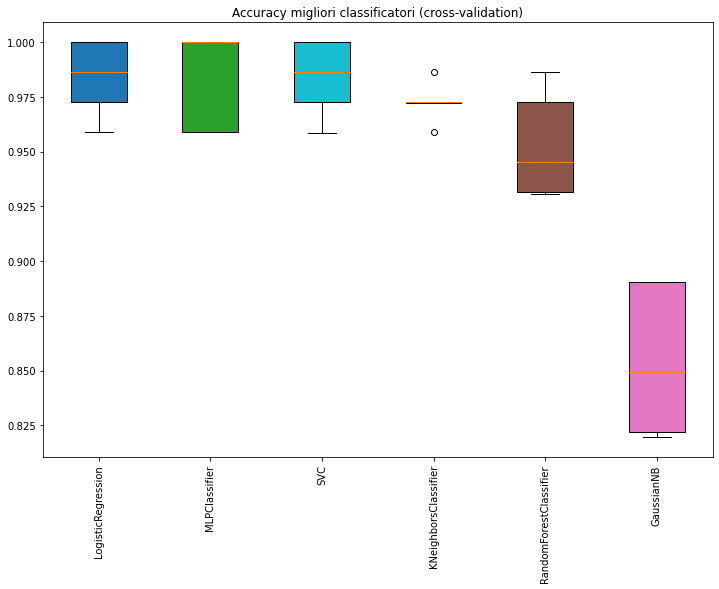

In [22]:
data_to_plot = results['kfold scores'].tolist()
labels = results['param_classifier'].tolist()
fig = plt.figure(1, figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_xticklabels(labels, rotation=90)
plt.title("Accuracy migliori classificatori (cross-validation)")

box = ax.boxplot(data_to_plot, patch_artist=True)
colors = ['tab:blue', 'tab:green', 'tab:cyan', 'tab:purple', 'tab:brown','tab:pink', 'tab:red']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

*Sono stati individuati e visualizzati i modelli migliori per ogni classificatore preso in considerazione. Le reti neurali, le SVM e la regressione logistica sono risultati i modelli migliori e pressoché equivalenti.*

Descrizione del modello migliore e della performance

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print('Miglior modello:\n{}\n'.format(best_model.best_estimator_))
pred_y = best_model.best_estimator_.predict(test_x)
print("Performance miglior modello con k-fold: {}% (accuracy)".format(round(gridsearch.best_score_*100,2)))
print("Performance miglior modello su test set: {}% (accuracy)\n".format(round(best_model.score(test_x,test_y)*100,2)))

Miglior modello:
Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('reducer', PCA()),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=10000,
                                    penalty='l1', random_state=0,
                                    solver='liblinear'))])

Performance miglior modello con k-fold: 98.36% (accuracy)
Performance miglior modello su test set: 97.8% (accuracy)



*Il classificatore migliore per il problema in esame risulta essere quello che utilizza come strategia di imputazione dei dati mancanti il valore medio, come metodo di scaling lo standard scaler (z-score) e come algoritmo di classificazione la regressione logistica con bilanciamento delle classi e regolarizzazione lasso.*

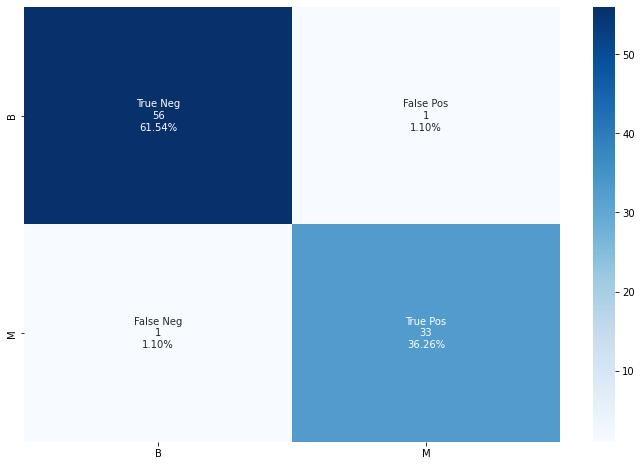

In [24]:
cf_matrix = confusion_matrix(test_y, pred_y)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix, xticklabels = ['B', 'M'], yticklabels= ['B', 'M'], annot=labels, fmt='', cmap='Blues')
plt.show()

*Nella matrice di confusione si osserva che non c'è uno sbilanciamento tra falsi positivi e falsi negativi.*

**Esportazione del modello**

In [25]:
dump(best_model.best_estimator_, 'breast_best_classifier.joblib', compress = 1) 

['breast_best_classifier.joblib']

*è stato esportato il miglior modello in un file joblib che può essere importato e applicato a nuovi dataset. L'esportazione comprende la strategia di imputazione, il metodo di scaling e il classificatore ottimizzato.*